In [18]:
# This is the COVID-19 analysis workbook
import pandas as pd
import ast
from ast import literal_eval
import configparser
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import re
import statsmodels.formula.api as smf

## COVID Date Setup
The dates for COVID-19 are set up in the below code.  The start of the COVID-19 pandemic shutdowns is chosen as March 13, 2020.  180 days, through March 12, 2020 are taken for data before the pandemic.  180 days starting March 13, 2020 are taken for data during the pandemic.

In [19]:
# Set up COVID dates
covid_date = pd.to_datetime('2020-03-13')
before_covid = covid_date - pd.DateOffset(days=180) 
during_covid = covid_date + pd.DateOffset(days=179) 
study_dates = pd.date_range(before_covid, during_covid)
before_covid, covid_date, during_covid, len(study_dates)

(Timestamp('2019-09-15 00:00:00'),
 Timestamp('2020-03-13 00:00:00'),
 Timestamp('2020-09-08 00:00:00'),
 360)

In [20]:
behavior = pd.read_csv('behaviors_pivoted_deID.csv',index_col = 0)

In [21]:
behaviors = behavior.copy()

In [22]:
config = configparser.ConfigParser()
config.read('targets_of_interest.ini')
targets = literal_eval(config['section1']['targets_of_interest'])

In [23]:
# demos = pd.read_csv('complete_demos.csv',index_col=0)
# print("Total individuals", len(demos))
# demos = demos[demos['Final_Res']==True]
# print("Residential individuals", len(demos))
# demos = demos[demos['Person_Diagnosis_ASD']==1]
# print("Individuals with ASD", len(demos))
# demos = demos[demos['Age_At_Covid_Date'] < 19]
# print("Pediatric Individuals", len(demos))
# demos = demos[~demos['behavior_date'].isna()]
# print("Individuals With Behavior Data", len(demos))
# demos = demos[demos['behavior_date'] <= demos['CovidFirstDate']]
# print("Individuals With Behavior Data Before Covid", len(demos))

In [24]:
eligible_ids = pd.read_csv('eligible_ids.csv')['Person_ID'].tolist()#demos['Person_ID'].unique().tolist()

In [25]:
behaviors = behaviors[behaviors['Person_ID'].isin(eligible_ids)]

In [26]:
behaviors

,Person_ID,Date,Behavior_aggression,Behavior_sib,Behavior_elopement,Behavior_disruptive,Behavior_Episodes_aggression,Behavior_Episodes_sib,Behavior_Episodes_elopement,Behavior_Episodes_disruptive
0,1,2019-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-09-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2019-09-17,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0
3,1,2019-09-18,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,2019-09-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25926,9,2020-08-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25927,9,2020-08-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25928,9,2020-08-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25929,9,2020-08-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Runs a paired test between two groups depending on the distribution of their differences

def paired_ttest_flowchart(groupA, groupB):
    stat, pvalue = stats.shapiro(groupA - groupB)
    if pvalue < 0.05:
        # print("not normal!")
        stat, pvalue = stats.wilcoxon(groupA - groupB)
        return pvalue
    else:
        stat, pvalue = stats.ttest_rel(groupA, groupB)
        return pvalue

# For LOO FDR analysis - where the initial test type has already been determined for the whole group
def paired_ttest_flowchart_det(groupA, groupB, pvalue):
    if pvalue < 0.05:
        # print("not normal!")
        stat, pvalue = stats.wilcoxon(groupA - groupB)
        return pvalue
    else:
        stat, pvalue = stats.ttest_rel(groupA, groupB)
        return pvalue


In [28]:
from sklearn.model_selection import LeaveOneOut
def loo_fdr(groupA, groupB):
    diff = groupA - groupB
    loo = LeaveOneOut()
    pvalues = []
    # stat, pvalue = stats.shapiro(groupA - groupB)
    for i, (train_index, test_index) in enumerate(loo.split(diff)):
        stat, pvalue = stats.shapiro(groupA[train_index] - groupB[train_index])
        pvalues.append(paired_ttest_flowchart_det(groupA[train_index], groupB[train_index], pvalue))
    pvalues = np.array(pvalues)
    fdr = sum(pvalues >= 0.05) / len(pvalues)
    return fdr
    
    

In [29]:
plt.rcParams.update({'font.size': 15})

plt.rcParams["font.family"] = "serif"
def plot_behs(merged, axs, target, episode, plot_letter):
    plt.rcParams.update({'font.size': 15})

    plt.rcParams["font.family"] = "serif"

    ids = merged['Person_ID'].unique().tolist()
    # print(len(ids))
    # print(target, ids)
    # fig, axs = plt.subplots(1, 1, figsize=(15,15), sharex = True, sharey = True)
    #axs = axs.ravel()
    color = [0.1, 0.2, 0.5]
    if episode:
        add_ep = 'Episodes_'
    else:
        add_ep = ''
    # Remove outliers
    # Where there is at least 50% change
    if target == 'All Challenging Behaviors':
        t = target
        target = 'all'

    # print(merged.columns)
    current = merged.groupby(['Date'])['Behavior_'+add_ep + target.lower()].agg('mean').copy().reset_index()
    current['Behavior_Avg'] = current['Behavior_'+add_ep + target.lower()].rolling(window=30,min_periods=10).mean()
    first_covid = merged.loc[merged['Covid']==True,'Date'].min()
    bc = current[current['Date'] <= first_covid]
    dc = current[current['Date'] >= first_covid]
    axs.plot(bc['Date'],bc['Behavior_Avg'], alpha = 1, color = 'black')
    axs.plot(dc['Date'],dc['Behavior_Avg'], alpha = 1, color = 'red')
    axs.legend(['Before COVID-19 moving avg', 'During COVID-19 moving avg'])
    for i in range(len(ids)):
        current = merged.loc[merged['Person_ID']==ids[i],:].copy()
        current = current.sort_values('Date',ascending=True)
        color[0]+=0.02
        current['Behavior_Avg'] = current['Behavior_' + add_ep + target.lower()].rolling(window=30,min_periods=10).mean()
        first_covid = current.loc[current['Covid']==True,'Date'].min()
        bc = current[current['Date'] <= first_covid]
        dc = current[current['Date'] >= first_covid]
        axs.plot(bc['Date'],bc['Behavior_Avg'], alpha = 0.2, color = 'black')
        axs.plot(dc['Date'],dc['Behavior_Avg'], alpha = 0.2, color = 'red')

    axs.set_xlabel('Date')
    if episode:
        axs.set_ylabel('Behavior Episode Count')
    else:
        axs.set_ylabel('Behavior (1) or not (0)')
    if target != 'all':
        t = target
    if t == 'sib':
        t = t.upper()
    else:
        t = t.title()
    if t == 'all':
        t = 'All Challenging Behaviors'
    if episode:

        plt.title(f'({plot_letter}) {t} Episodes Over Time')
    else:
        plt.title(f'({plot_letter}) {t} Days Over Time')
    t = t.split('/')[0]
    if episode:
        ep = ''
    else:
        ep = 'days'
    
    plt.savefig(f'outputs/{t}_{episode}behaviors.png')

In [30]:
behaviors

,Person_ID,Date,Behavior_aggression,Behavior_sib,Behavior_elopement,Behavior_disruptive,Behavior_Episodes_aggression,Behavior_Episodes_sib,Behavior_Episodes_elopement,Behavior_Episodes_disruptive
0,1,2019-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-09-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2019-09-17,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0
3,1,2019-09-18,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,2019-09-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25926,9,2020-08-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25927,9,2020-08-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25928,9,2020-08-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25929,9,2020-08-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
behaviors[behaviors['Behavior_disruptive'].isna() & ~behaviors['Behavior_aggression'].isna()]

,Person_ID,Date,Behavior_aggression,Behavior_sib,Behavior_elopement,Behavior_disruptive,Behavior_Episodes_aggression,Behavior_Episodes_sib,Behavior_Episodes_elopement,Behavior_Episodes_disruptive
1110,12,2019-10-15,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
1184,12,2019-12-28,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
1185,12,2019-12-29,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
1187,12,2019-12-31,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
1207,12,2020-01-20,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
19423,6,2019-10-17,0.0,1.0,0.0,NaN,0.0,7.0,0.0,NaN
19444,6,2019-11-07,0.0,1.0,0.0,NaN,0.0,2.0,0.0,NaN
19480,6,2019-12-13,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
19489,6,2019-12-22,1.0,0.0,0.0,NaN,4.0,0.0,0.0,NaN


In [32]:

outlier_analysis = False
def get_behaviors_and_plot(behaviors, targets, covid_date, episode):
    covid_date = pd.to_datetime(covid_date)
    behaviors['Date'] = pd.to_datetime(behaviors['Date'])
    bc = behaviors[behaviors['Date'] < covid_date].copy()
    ac = behaviors[behaviors['Date'] >= covid_date].copy()

    
    
    
    df = {}
    df['Person_ID'] = eligible_ids
    df['Date'] = [study_dates.tolist() for x in range(len(eligible_ids))]
    df = pd.DataFrame(df)
    df = df.explode('Date')
    df['Covid'] = (df['Date'] >= covid_date).copy()
    df['Months'] = ((df['Date']- before_covid) / np.timedelta64(30, 'D')).astype(int)

    merged = df.merge(behaviors, on = ['Person_ID','Date'], how = 'left')
 
    if episode:
        add_ep = "Episodes_"
    else:
        add_ep = ''

    if len(targets[0]) > 1:


        all_cols = ['Behavior_'+add_ep+target for target in targets]
        targets = 'all'
        merged['Behavior_'+add_ep+targets] = merged[all_cols].sum(axis=1,min_count=1)

      
        if episode:
            merged['Behavior_'+add_ep+targets] = np.where(merged['Behavior_'+add_ep+targets].isna(),
                                                        float("NaN"),
                                                        (merged['Behavior_'+add_ep+targets]))
        else:
            merged['Behavior_'+add_ep+targets] = np.where(merged['Behavior_'+add_ep+targets].isna(),
                                                        float("NaN"),
                                                        (merged['Behavior_'+add_ep+targets] > 0) * 1.0)


    merged = merged[['Person_ID','Date','Behavior_'+add_ep+targets,'Covid','Months']]
    merged['Months'] = ((merged['Date']- before_covid) / np.timedelta64(30, 'D')).astype(int)
    merged['Concat'] = merged['Person_ID'].astype(str) + " " + merged['Date'].astype(str)
    merged_for_average = merged.copy()
    # merged = merged.dropna()
  
    count_behaviors = merged.dropna().groupby(['Person_ID','Covid','Months']).agg('count').reset_index()

    # At least 10 days per month must be recorded
    count_behaviors['Eligible'] = (count_behaviors['Behavior_'+add_ep+targets] / 30) >= (1/3)

    enough_data = count_behaviors.groupby('Person_ID').agg({'Eligible':'sum'})
    final_ids = enough_data[enough_data['Eligible'] == 12].index

    merged = merged[merged['Person_ID'].isin(final_ids.tolist())]

    

    ids = (merged.groupby('Person_ID')['Behavior_'+add_ep+targets].agg('sum') > 0)
    ids = ids[ids==True].index.tolist()
    print(ids)
    merged = merged[merged['Person_ID'].isin(ids)].copy()
    merged_for_average = merged_for_average[merged_for_average['Person_ID'].isin(ids)].copy()
    out_targ = ""
    if len(targets[0]) > 1:
        out_targ = "all" 
    else:
        out_targ = targets
    merged.to_csv("outputs/"+out_targ+str(episode)+"new.csv")


    covid_before_aft = merged.groupby(['Person_ID','Covid']).agg({'Behavior_'+add_ep+targets:'mean'}).reset_index()
    pivoted = covid_before_aft.pivot_table('Behavior_'+add_ep+targets,['Person_ID',],'Covid').reset_index()
    pivoted['Percent_Change'] = abs(pivoted[False] - pivoted[True]) #abs((pivoted[False] - pivoted[True]) / (pivoted[False] + 0.00001)) * 100
    
    pivoted = pivoted.sort_values('Percent_Change',ascending=False)
    # print(pivoted)
   
    # Perform ttest on averages
    ttest = merged.groupby(['Person_ID','Covid'])['Behavior_'+add_ep+targets].agg('mean').reset_index().pivot(index='Person_ID',columns='Covid', values='Behavior_'+add_ep+targets).reset_index()
    pvalue = paired_ttest_flowchart(ttest[False].astype(float).to_numpy(),ttest[True].astype(float).to_numpy())
    fdr = loo_fdr(ttest[False].astype(float).to_numpy(),ttest[True].astype(float).to_numpy())
    #return ttest, stats.ttest_rel(ttest[False],ttest[True])[1], merged
    return ttest, pvalue, merged, pivoted, ids, merged_for_average, fdr

# Create LaTeX table
episodes = [True, False]
pvalues = []
behs = []
tabs = []
targs =[]
pivots = []
fdrs = []
individuals = []
moving_averages = []
for episode in episodes:
    print(episode)
    if episode:
        st = """\\begin{table}[H] 
        \caption{Statistics of challenging behavior episodes over time\label{tab1}}
        \\begin{tabularx}{\\textwidth}{CCCCC}
        \\toprule
        \\textbf{Behavior Type}	& \\textbf{Before Covid Mean} & \\textbf{During Covid Mean}& \\textbf{p-value} & \\textbf{FDR}  & \\textbf{n} \\\\
        \midrule"""
    else:
        st = """\\begin{table}[H] 
        \caption{Statistics of challenging behavior days over time\label{tab1}}
        \\begin{tabularx}{\\textwidth}{CCCCC}
        \\toprule
        \\textbf{Behavior Type}	& \\textbf{Before Covid Mean} & \\textbf{During Covid Mean}& \\textbf{p-value} & \\textbf{FDR} & \\textbf{n} \\\\
        \midrule"""

    fig= plt.figure()
    tab, pval, beh, pivot, ids, merged_for_average, fdr = get_behaviors_and_plot(behaviors, targets, covid_date, episode)
    pvalues.append(pval)
    fdrs.append(fdr)
    tabs.append(tab)
    behs.append(beh)
    pivots.append(pivot)
    individuals.append(ids)
    moving_averages.append(merged_for_average)
    st = st + """
    """ + "All Challenging Behaviors" + " & " + str(round(tab[False].mean(),3)) + " & " + str(round(tab[True].mean(),3)) + " & " + str(round(pval,3)) + " & " + str(round(fdr,3)) + " & " + str(len(tab))+ "\\\\" 
    targs.append("All Challenging Behaviors")

    for target in targets:
        
        tab, pval, beh, pivot, ids, merged_for_average, fdr = get_behaviors_and_plot(behaviors, target, covid_date, episode)
        pvalues.append(pval)
        tabs.append(tab)
        behs.append(beh)
        pivots.append(pivot)
        individuals.append(ids)
        moving_averages.append(merged_for_average)
        fdrs.append(fdr)
        targ_string = target
        if targ_string == "sib":
            targ_string = "SIB"
        else:
            targ_string = targ_string.title()
        st = st + """
        """ + targ_string + " & " + str(round(tab[False].mean(),3)) + " & " + str(round(tab[True].mean(),3)) + " & " + str(round(pval,3)) + " & " + str(round(fdr,3)) + " & " + str(len(tab)) +"\\\\" 
        targs.append(targ_string)

    a = """
    \\bottomrule
    \end{tabularx}
    \end{table}"""
    if outlier_analysis:
        outs = '_outliers'
    else:
        outs = ''
    st = st + a
    with open(f'outputs/{episode}_stats{outs}.txt','w') as textfile:
        print(episode)
        print(outs)
        textfile.write(st)
    # for p in pivots:
    #     diffs_o = p[False] - p[True]
    #     diffs = diffs_o.to_numpy()
    #     q1 = np.quantile(diffs, 0.25)
    #     q3 = np.quantile(diffs, 0.75)
    #     outliers_hi = q3 +  (q3 - q1) * 1.5
    #     outliers_lo = q1-  (q3 - q1) * 1.5
    #     print("Hi outliers:", diffs_o[diffs_o > outliers_hi])
    #     print("Lo outliers:", diffs_o[diffs_o < outliers_lo])




True
[1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 11.0, 14.0, 15.0, 16.0, 17.0, 18.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 35.0, 36.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 51.0, 53.0, 54.0, 55.0, 56.0, 57.0, 61.0, 62.0, 73.0]
[1.0, 3.0, 4.0, 5.0, 7.0, 8.0, 11.0, 14.0, 15.0, 16.0, 17.0, 18.0, 20.0, 21.0, 22.0, 23.0, 25.0, 26.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 35.0, 36.0, 39.0, 41.0, 42.0, 44.0, 45.0, 46.0, 47.0, 48.0, 51.0, 53.0, 54.0, 55.0, 61.0, 62.0, 73.0]
[1.0, 3.0, 4.0, 5.0, 14.0, 16.0, 17.0, 20.0, 21.0, 22.0, 24.0, 25.0, 26.0, 28.0, 30.0, 33.0, 35.0, 36.0, 39.0, 40.0, 42.0, 53.0, 54.0, 62.0]
[3.0, 4.0, 8.0, 11.0, 15.0, 18.0, 20.0, 21.0, 25.0, 27.0, 29.0, 30.0, 31.0, 32.0, 36.0, 43.0, 44.0, 48.0, 51.0, 55.0, 56.0, 62.0]
[1.0, 2.0, 3.0, 4.0, 7.0, 11.0, 15.0, 16.0, 17.0, 20.0, 21.0, 22.0, 24.0, 25.0, 26.0, 27.0, 28.0, 30.0, 31.0, 32.0, 33.0, 35.0, 36.0, 39.0, 40.0, 43.0, 44.0, 46.0, 51.0, 53.0, 54.0, 55.0, 57.0, 62.0, 7

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

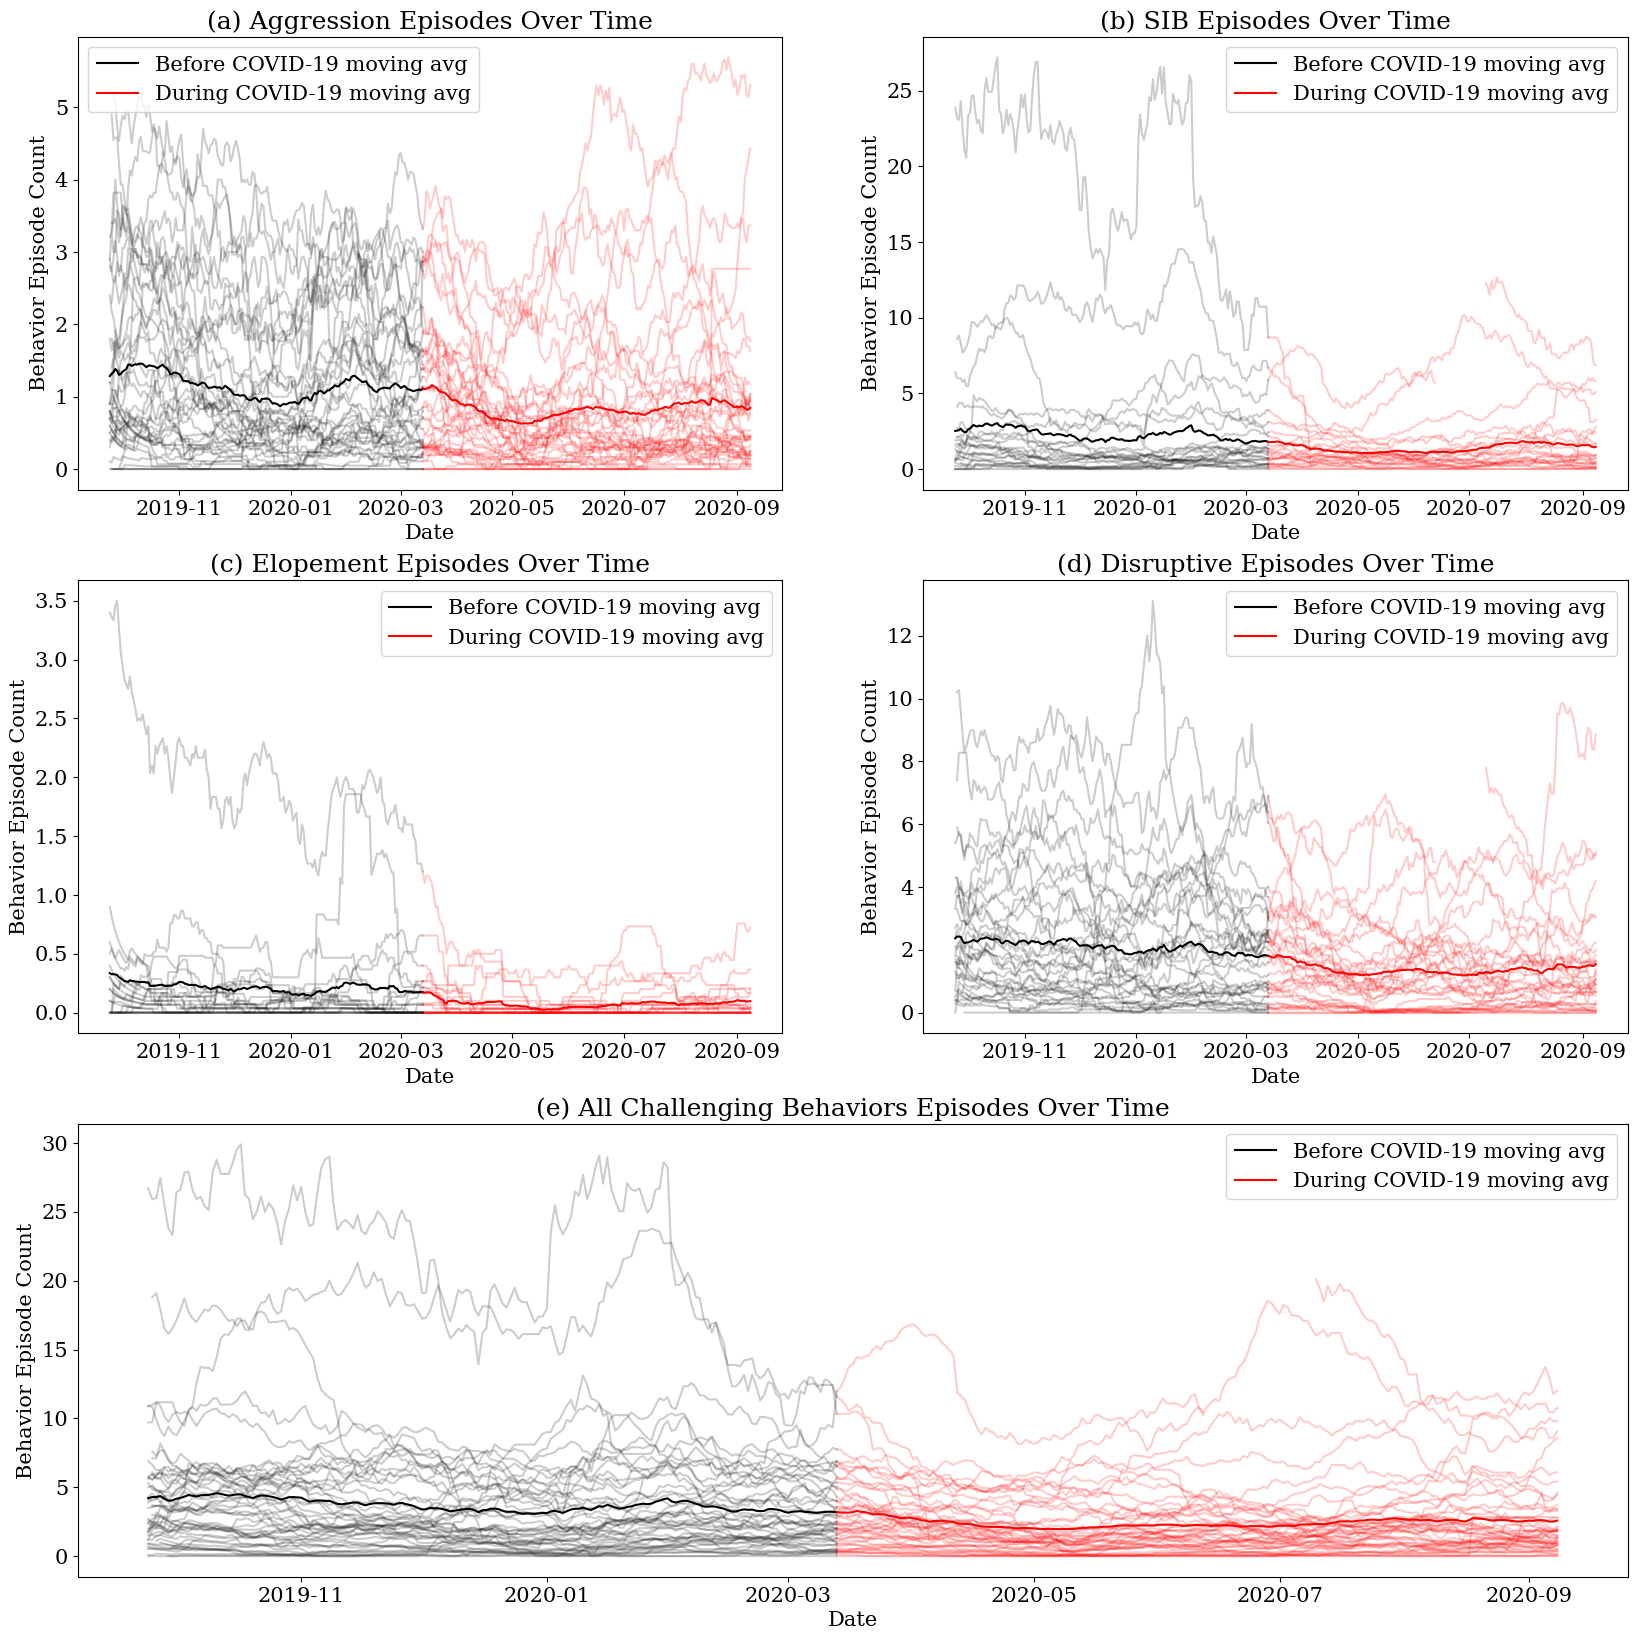

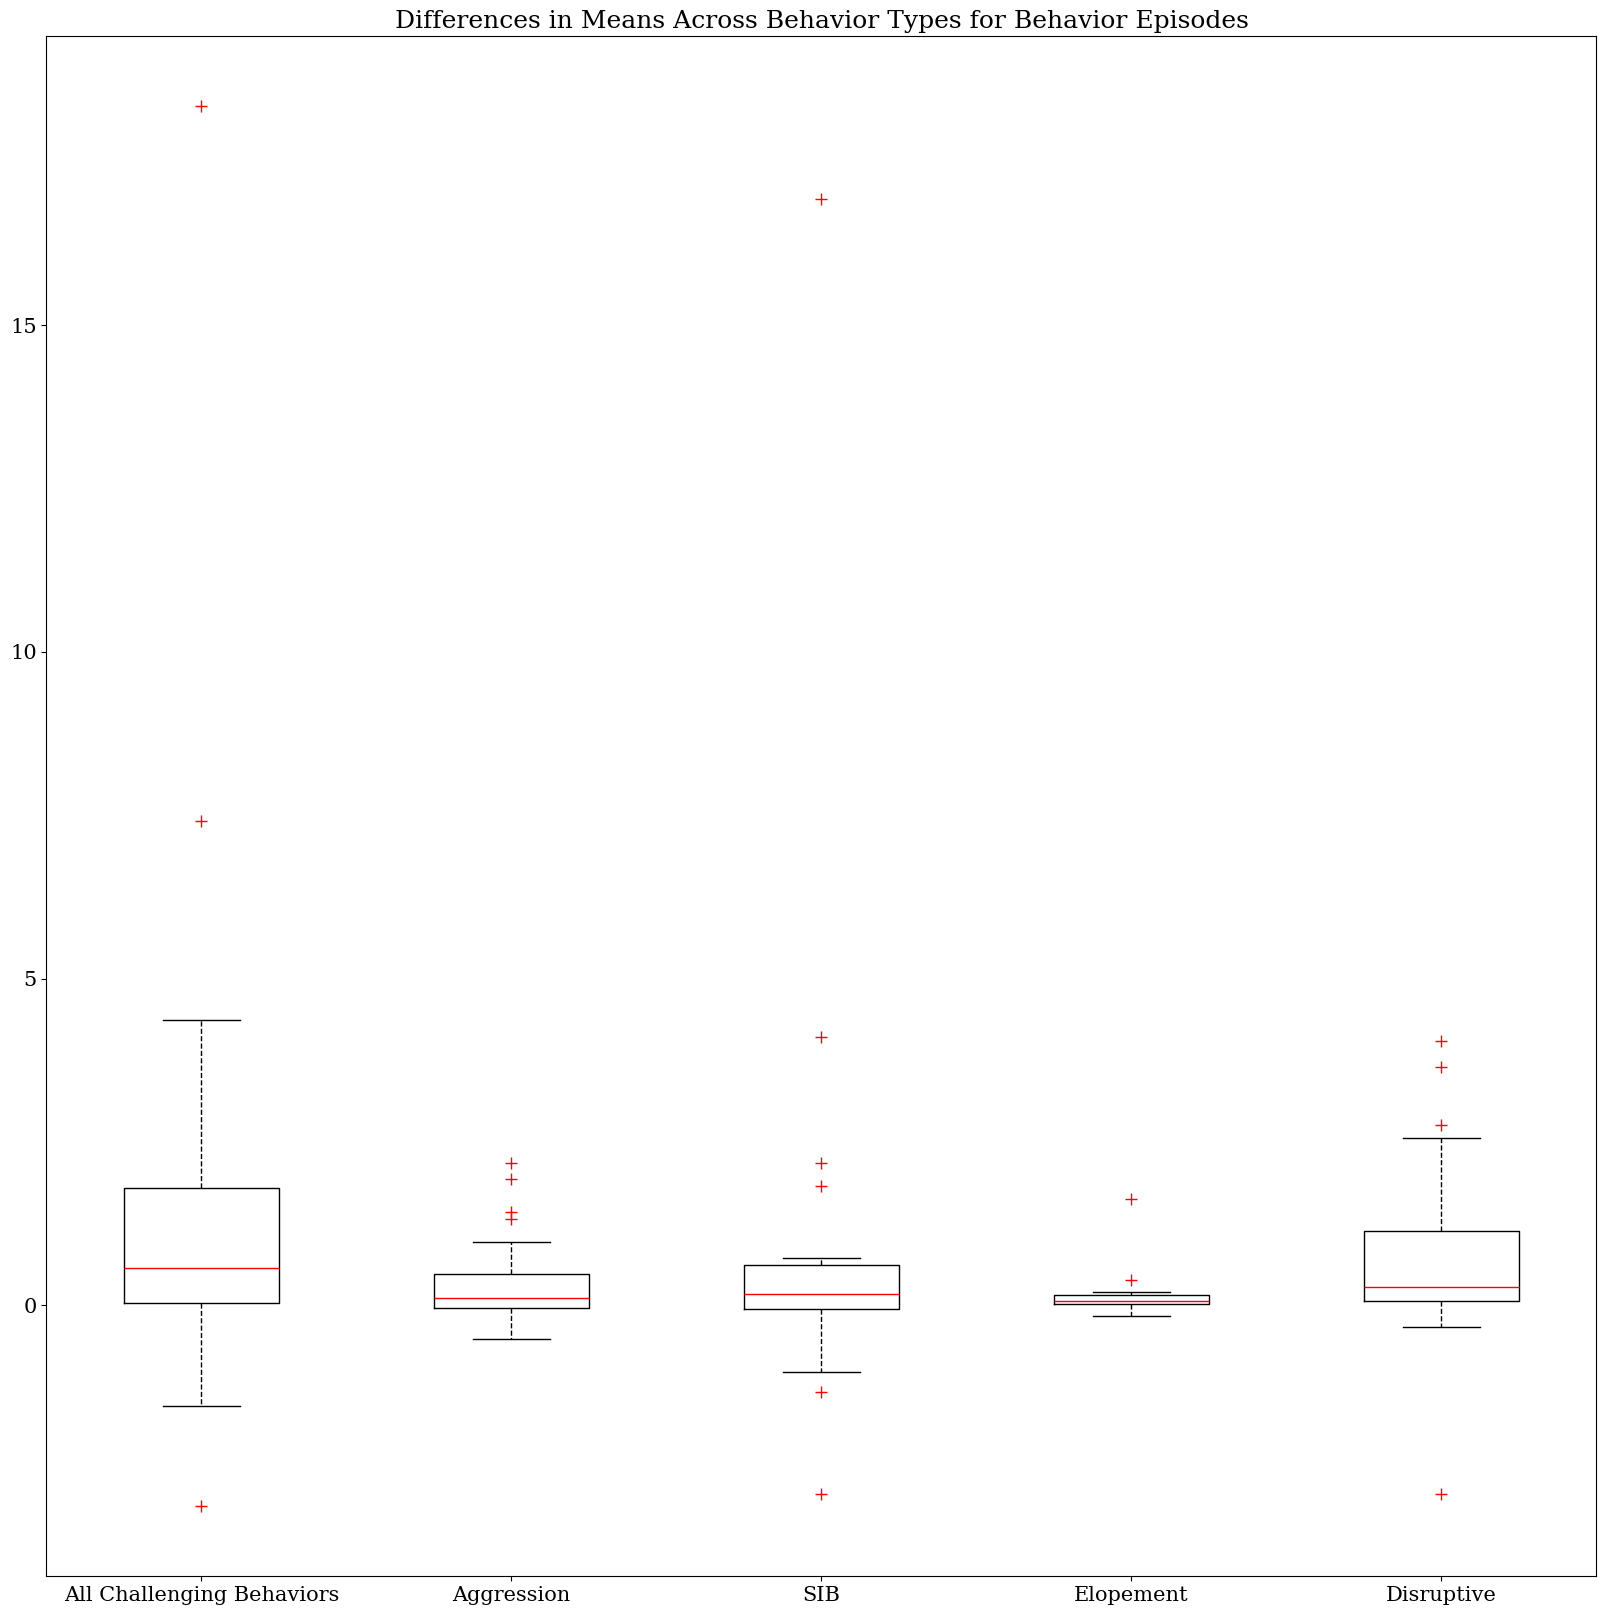

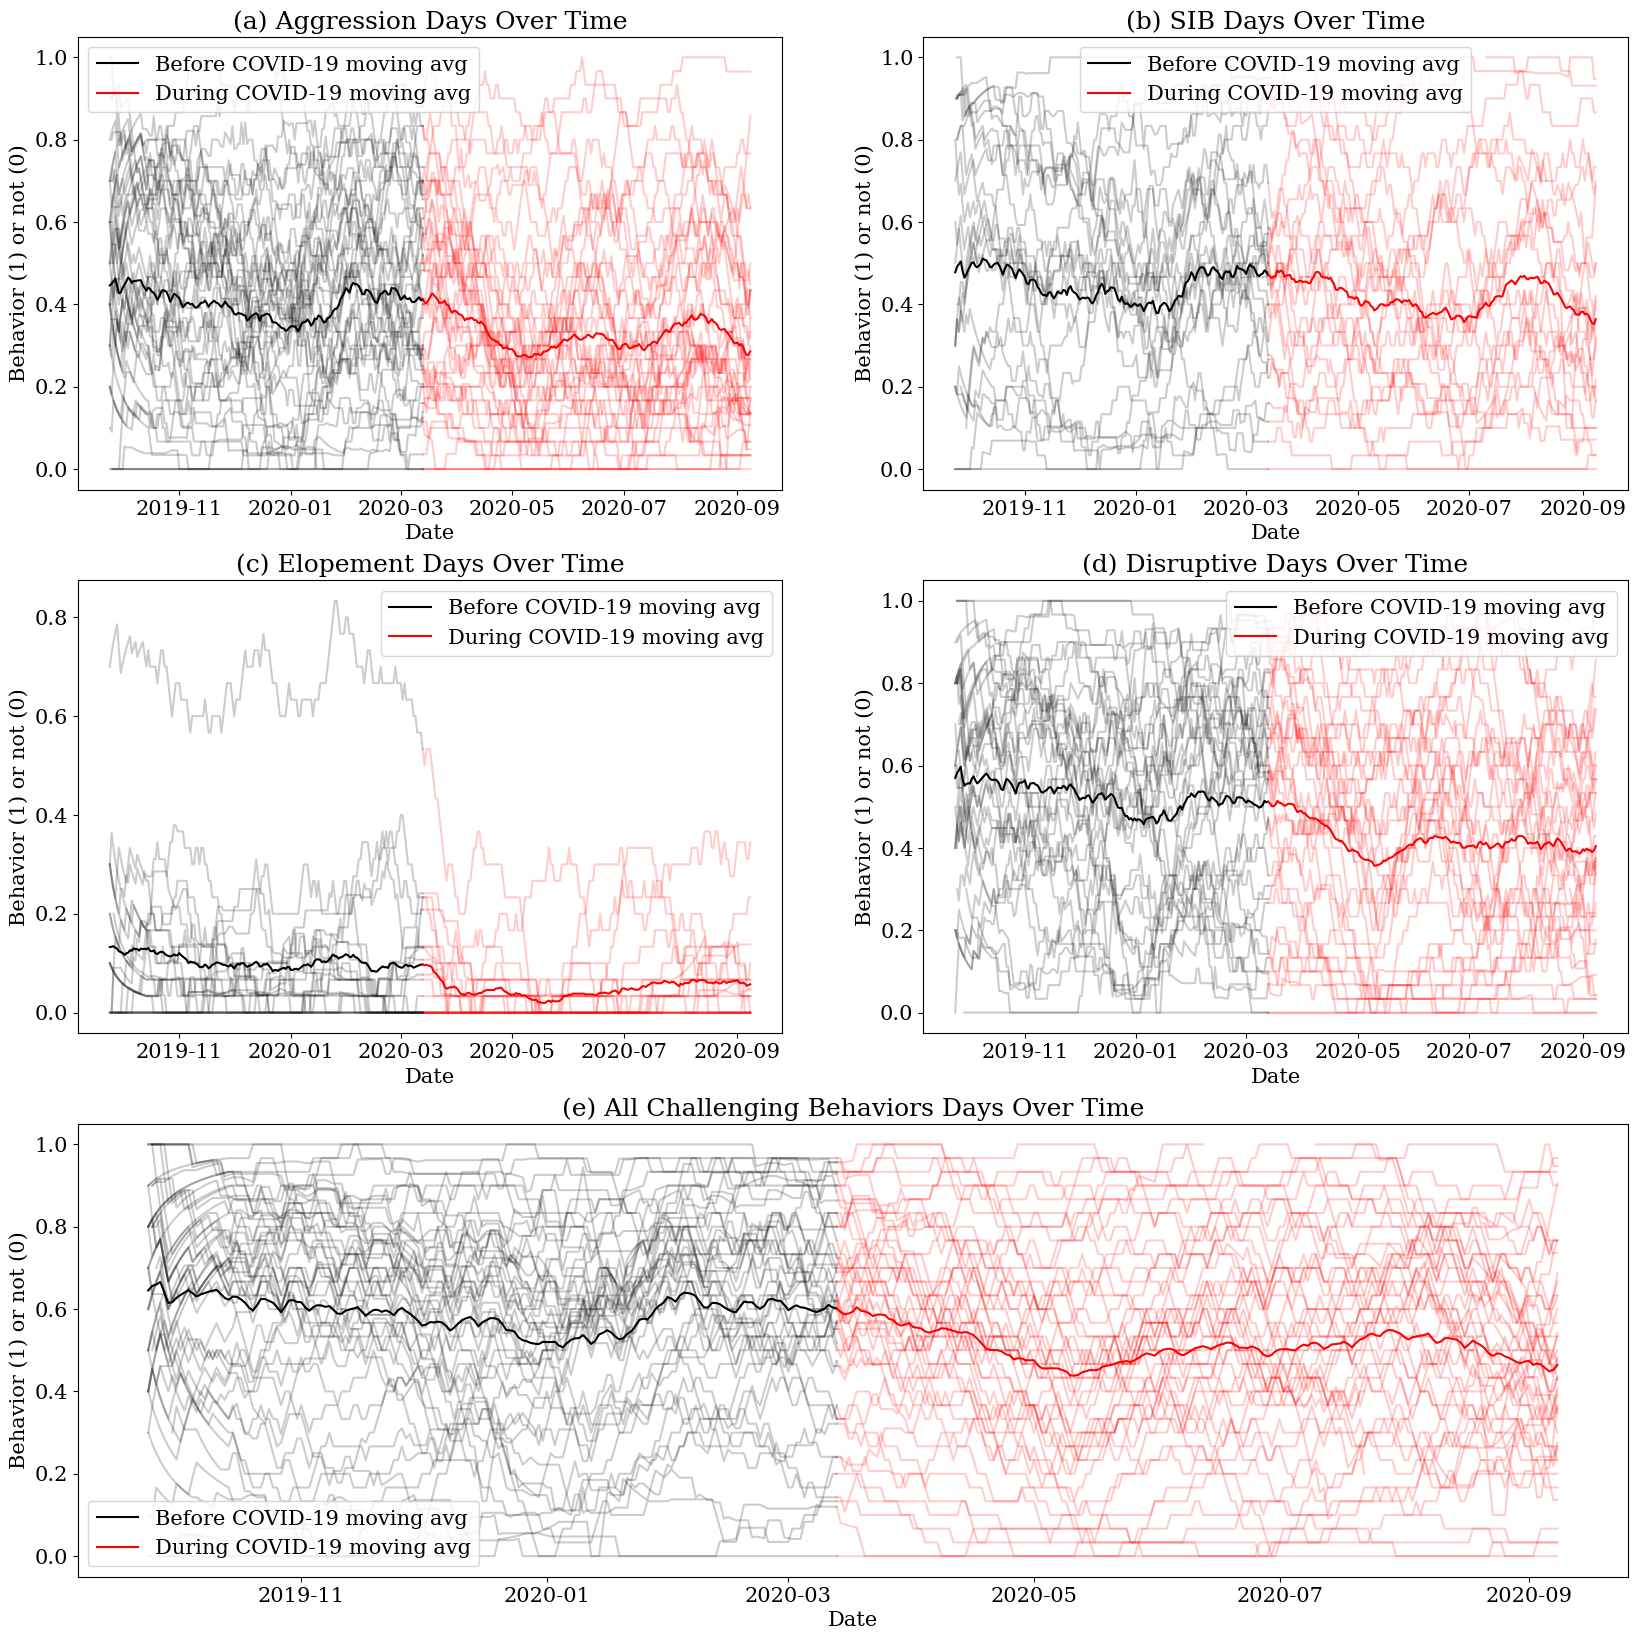

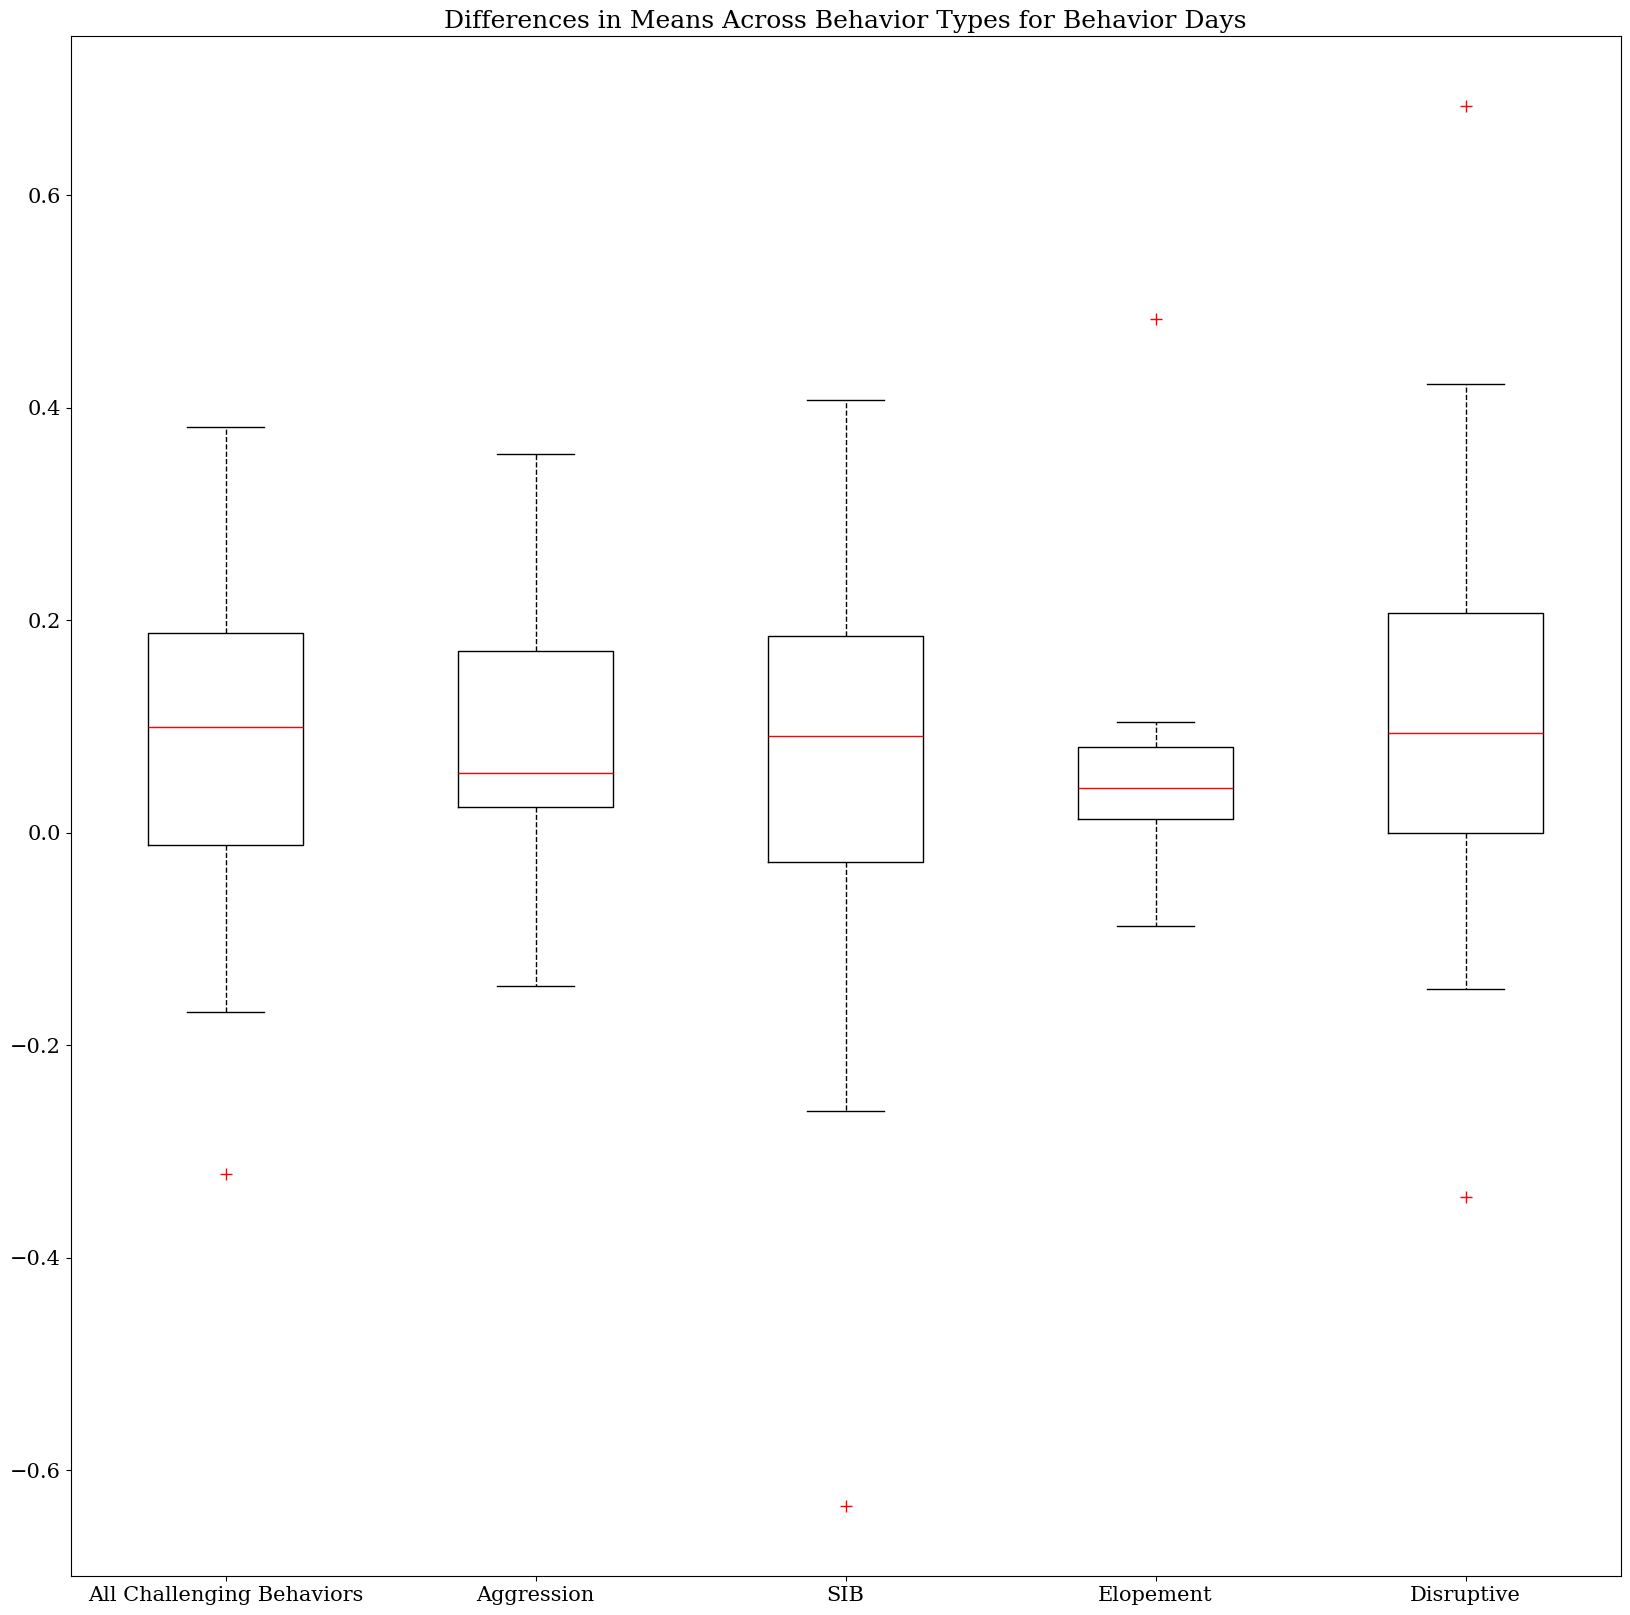

In [33]:

def plot_behaviors(behs, targets, ep, pivots):
    
    fig = plt.figure(figsize=(20,20))
    fig.tight_layout(rect=[0, 0.03, 1, 0.975])
    gs = fig.add_gridspec(3,2)
    
    letters = '0abcdefghijklm'
    for i in range(1,len(targets)):
        ax = fig.add_subplot(gs[i-1])
        t = targets[i]
        # print(t)
        if t == 'SIB':
            t = 'sib'
        plot_behs(behs[i],ax,t,ep,letters[i])
    ax = fig.add_subplot(gs[-1,:])
    t = targets[0]
    # print(t)
    plot_behs(behs[0],ax,t,ep,letters[i+1])
    box = plt.figure(figsize=(20,20))
    flierprops = dict(marker='+', markerfacecolor='red', markersize=8,
                  markeredgecolor='red', label='')
    medianprops = dict( color='red')

    whiskerprops = dict(linestyle='--')

    plt.boxplot([pivot[False] - pivot[True] for pivot in pivots], flierprops=flierprops, medianprops=medianprops,whiskerprops=whiskerprops)
    if ep:
        title_word = 'Episodes'
    else:
        title_word = 'Days'
    title = 'Differences in Means Across Behavior Types for Behavior ' + title_word
    plt.title(title)
    ax = plt.gca()
    ax.set_xticklabels(targets)

    plt.show()


def split_list(a_list):
    half = len(a_list)//2
    return a_list[:half], a_list[half:]


# Break targs and behs in half
behs1, behs2 = split_list(moving_averages)
targs1, targs2 = split_list(targs)
pivots1, pivots2 = split_list(pivots)

plot_behaviors(behs1, targs1, True, pivots1)
plot_behaviors(behs2, targs2, False, pivots2)

In [34]:
def read_exception_dates(filename):
    date_closures = []
    with open(filename,'r') as f:
        lines = f.readlines()
        for line in lines:
            if len(''.join(line.split())) != 0:
                if len(line.split()) == 3:
                    spl = line.split()
                    sdate = pd.to_datetime(spl[0])
                    edate = pd.to_datetime(spl[2])
                    date_closures.extend(pd.date_range(sdate,edate,freq='d'))
                else:
                    date_closures.append(pd.to_datetime(line))

    return date_closures

date_closures = read_exception_dates('closure_dates.txt')
date_school = read_exception_dates('school_dates.txt')

In [35]:
date_closures

[Timestamp('2020-09-07 00:00:00'),
 Timestamp('2020-10-12 00:00:00'),
 Timestamp('2020-11-11 00:00:00'),
 Timestamp('2020-11-25 00:00:00'),
 Timestamp('2020-11-26 00:00:00'),
 Timestamp('2020-11-27 00:00:00'),
 Timestamp('2019-10-14 00:00:00'),
 Timestamp('2019-11-11 00:00:00'),
 Timestamp('2019-11-27 00:00:00'),
 Timestamp('2019-11-28 00:00:00'),
 Timestamp('2019-11-29 00:00:00'),
 Timestamp('2020-01-20 00:00:00'),
 Timestamp('2020-02-17 00:00:00'),
 Timestamp('2020-03-20 00:00:00'),
 Timestamp('2020-05-25 00:00:00'),
 Timestamp('2020-05-26 00:00:00'),
 Timestamp('2019-01-16 00:00:00'),
 Timestamp('2019-01-21 00:00:00'),
 Timestamp('2019-02-15 00:00:00'),
 Timestamp('2019-02-18 00:00:00'),
 Timestamp('2019-03-15 00:00:00'),
 Timestamp('2019-03-29 00:00:00'),
 Timestamp('2019-05-24 00:00:00'),
 Timestamp('2019-05-27 00:00:00'),
 Timestamp('2020-03-16 00:00:00'),
 Timestamp('2020-03-17 00:00:00'),
 Timestamp('2020-03-18 00:00:00'),
 Timestamp('2020-03-19 00:00:00'),
 Timestamp('2020-03-

In [36]:
all_behavior_episodes = behs[0].copy()
col = [col for col in all_behavior_episodes if 'Behavior' in col]
all_behavior_episodes.rename(columns={col[0]:'Episodes'}, inplace=True)
all_behavior_days = behs[5].copy()
col = [col for col in all_behavior_days if 'Behavior' in col]
all_behavior_days.rename(columns={col[0]:'Behavior'}, inplace=True)
print(all_behavior_days.columns)
all_behaviors_total = all_behavior_episodes.merge(all_behavior_days)

Index(['Person_ID', 'Date', 'Behavior', 'Covid', 'Months', 'Concat'], dtype='object')


In [37]:
all_behaviors_total.columns

Index(['Person_ID', 'Date', 'Episodes', 'Covid', 'Months', 'Concat',
       'Behavior'],
      dtype='object')

In [38]:
all_behaviors_total

,Person_ID,Date,Episodes,Covid,Months,Concat,Behavior
0,21.0,2019-09-15,0.0,False,0,21.0 2019-09-15,0.0
1,21.0,2019-09-16,0.0,False,0,21.0 2019-09-16,0.0
2,21.0,2019-09-17,0.0,False,0,21.0 2019-09-17,0.0
3,21.0,2019-09-18,1.0,False,0,21.0 2019-09-18,1.0
4,21.0,2019-09-19,1.0,False,0,21.0 2019-09-19,1.0
...,...,...,...,...,...,...,...
17275,27.0,2020-09-04,1.0,True,11,27.0 2020-09-04,1.0
17276,27.0,2020-09-05,2.0,True,11,27.0 2020-09-05,1.0
17277,27.0,2020-09-06,5.0,True,11,27.0 2020-09-06,1.0
17278,27.0,2020-09-07,5.0,True,11,27.0 2020-09-07,1.0


In [39]:
covid_before_aft = all_behavior_days.groupby(['Person_ID','Covid']).agg({'Behavior':'mean'}).reset_index()
pivoted = covid_before_aft.pivot_table('Behavior',['Person_ID',],'Covid').reset_index()

In [40]:
# all_behaviors_total = all_behaviors_total.merge(demos, how = 'left')

In [41]:

all_behaviors_total['Weekend'] = (all_behaviors_total['Date'].dt.dayofweek.isin([5,6]) * 1.0).astype(int)
all_behaviors_total['Unexpected_Closure'] = ((all_behaviors_total['Date'].isin(date_closures) & (all_behaviors_total['Weekend'] == 0)) * 1.0).astype(int)
all_behaviors_total['School'] = ((all_behaviors_total['Date'].isin(date_school)& (all_behaviors_total['Weekend'] == 0) * (all_behaviors_total['Unexpected_Closure'] == 0)) * 1.0).astype(int)

In [42]:
date_closures

[Timestamp('2020-09-07 00:00:00'),
 Timestamp('2020-10-12 00:00:00'),
 Timestamp('2020-11-11 00:00:00'),
 Timestamp('2020-11-25 00:00:00'),
 Timestamp('2020-11-26 00:00:00'),
 Timestamp('2020-11-27 00:00:00'),
 Timestamp('2019-10-14 00:00:00'),
 Timestamp('2019-11-11 00:00:00'),
 Timestamp('2019-11-27 00:00:00'),
 Timestamp('2019-11-28 00:00:00'),
 Timestamp('2019-11-29 00:00:00'),
 Timestamp('2020-01-20 00:00:00'),
 Timestamp('2020-02-17 00:00:00'),
 Timestamp('2020-03-20 00:00:00'),
 Timestamp('2020-05-25 00:00:00'),
 Timestamp('2020-05-26 00:00:00'),
 Timestamp('2019-01-16 00:00:00'),
 Timestamp('2019-01-21 00:00:00'),
 Timestamp('2019-02-15 00:00:00'),
 Timestamp('2019-02-18 00:00:00'),
 Timestamp('2019-03-15 00:00:00'),
 Timestamp('2019-03-29 00:00:00'),
 Timestamp('2019-05-24 00:00:00'),
 Timestamp('2019-05-27 00:00:00'),
 Timestamp('2020-03-16 00:00:00'),
 Timestamp('2020-03-17 00:00:00'),
 Timestamp('2020-03-18 00:00:00'),
 Timestamp('2020-03-19 00:00:00'),
 Timestamp('2020-03-

In [43]:
# all_behaviors_total = all_behaviors_total.drop('Months',axis=1)
# all_behaviors_total = all_behaviors_total.dropna()

In [44]:
all_behaviors_total

,Person_ID,Date,Episodes,Covid,Months,Concat,Behavior,Weekend,Unexpected_Closure,School
0,21.0,2019-09-15,0.0,False,0,21.0 2019-09-15,0.0,1,0,0
1,21.0,2019-09-16,0.0,False,0,21.0 2019-09-16,0.0,0,0,1
2,21.0,2019-09-17,0.0,False,0,21.0 2019-09-17,0.0,0,0,1
3,21.0,2019-09-18,1.0,False,0,21.0 2019-09-18,1.0,0,0,1
4,21.0,2019-09-19,1.0,False,0,21.0 2019-09-19,1.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
17275,27.0,2020-09-04,1.0,True,11,27.0 2020-09-04,1.0,0,0,1
17276,27.0,2020-09-05,2.0,True,11,27.0 2020-09-05,1.0,1,0,0
17277,27.0,2020-09-06,5.0,True,11,27.0 2020-09-06,1.0,1,0,0
17278,27.0,2020-09-07,5.0,True,11,27.0 2020-09-07,1.0,0,1,0


In [45]:
all_behaviors_total['Person_Old'] = all_behaviors_total['Person_ID'].copy()
all_behaviors_total['Person_ID'] = all_behaviors_total['Person_ID'].astype('category').cat.codes.astype(int)

In [46]:
all_behaviors_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17280 entries, 0 to 17279
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Person_ID           17280 non-null  int32         
 1   Date                17280 non-null  datetime64[ns]
 2   Episodes            16218 non-null  float64       
 3   Covid               17280 non-null  bool          
 4   Months              17280 non-null  int32         
 5   Concat              17280 non-null  object        
 6   Behavior            16218 non-null  float64       
 7   Weekend             17280 non-null  int32         
 8   Unexpected_Closure  17280 non-null  int32         
 9   School              17280 non-null  int32         
 10  Person_Old          17280 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int32(5), object(1)
memory usage: 1.0+ MB


In [47]:
# all_behaviors_total['Behavior']  = (all_behaviors_total['Behavior'] * 1.0).astype(int)
# all_behaviors_total['Covid'] = (all_behaviors_total['Covid'] * 1.0).astype(int)

In [48]:
all_behaviors_total['Person_Old'].unique()

array([21., 41., 22., 14., 20., 44., 32.,  7., 23., 62.,  8.,  1.,  4.,
       56., 55., 36.,  5., 43., 24., 40.,  2., 61., 30., 17., 51., 42.,
        3., 39., 54., 53., 11., 45., 16., 57., 33., 73., 25., 28., 35.,
       29., 46., 48., 26., 31., 15., 18., 47., 27.])

In [49]:
# P51575 = all_behaviors_total[all_behaviors_total['Person_Old']=='P51575'].copy()
# P51575.tail(60)

In [50]:
study_dates

DatetimeIndex(['2019-09-15', '2019-09-16', '2019-09-17', '2019-09-18',
               '2019-09-19', '2019-09-20', '2019-09-21', '2019-09-22',
               '2019-09-23', '2019-09-24',
               ...
               '2020-08-30', '2020-08-31', '2020-09-01', '2020-09-02',
               '2020-09-03', '2020-09-04', '2020-09-05', '2020-09-06',
               '2020-09-07', '2020-09-08'],
              dtype='datetime64[ns]', length=360, freq='D')

In [51]:
st = {study_dates[i]:i+1 for i in range(len(study_dates))}

In [52]:
all_behaviors_total['Time'] = all_behaviors_total['Date'].map(st)

In [53]:
all_behaviors_total

,Person_ID,Date,Episodes,Covid,Months,Concat,Behavior,Weekend,Unexpected_Closure,School,Person_Old,Time
0,14,2019-09-15,0.0,False,0,21.0 2019-09-15,0.0,1,0,0,21.0,1
1,14,2019-09-16,0.0,False,0,21.0 2019-09-16,0.0,0,0,1,21.0,2
2,14,2019-09-17,0.0,False,0,21.0 2019-09-17,0.0,0,0,1,21.0,3
3,14,2019-09-18,1.0,False,0,21.0 2019-09-18,1.0,0,0,1,21.0,4
4,14,2019-09-19,1.0,False,0,21.0 2019-09-19,1.0,0,0,1,21.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
17275,20,2020-09-04,1.0,True,11,27.0 2020-09-04,1.0,0,0,1,27.0,356
17276,20,2020-09-05,2.0,True,11,27.0 2020-09-05,1.0,1,0,0,27.0,357
17277,20,2020-09-06,5.0,True,11,27.0 2020-09-06,1.0,1,0,0,27.0,358
17278,20,2020-09-07,5.0,True,11,27.0 2020-09-07,1.0,0,1,0,27.0,359


In [54]:
all_behaviors_total['Date']

0       2019-09-15
1       2019-09-16
2       2019-09-17
3       2019-09-18
4       2019-09-19
           ...    
17275   2020-09-04
17276   2020-09-05
17277   2020-09-06
17278   2020-09-07
17279   2020-09-08
Name: Date, Length: 17280, dtype: datetime64[ns]

In [55]:
# import statsmodels.api as sm
# lm = smf.mixedlm('Behavior ~ Time * Covid + Unexpected_Closure + School + Weekend',data = all_behaviors_total,
#             groups = all_behaviors_total['Person_ID'])
# result = lm.fit()
# result.summary()

In [56]:
all_behaviors_total

,Person_ID,Date,Episodes,Covid,Months,Concat,Behavior,Weekend,Unexpected_Closure,School,Person_Old,Time
0,14,2019-09-15,0.0,False,0,21.0 2019-09-15,0.0,1,0,0,21.0,1
1,14,2019-09-16,0.0,False,0,21.0 2019-09-16,0.0,0,0,1,21.0,2
2,14,2019-09-17,0.0,False,0,21.0 2019-09-17,0.0,0,0,1,21.0,3
3,14,2019-09-18,1.0,False,0,21.0 2019-09-18,1.0,0,0,1,21.0,4
4,14,2019-09-19,1.0,False,0,21.0 2019-09-19,1.0,0,0,1,21.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
17275,20,2020-09-04,1.0,True,11,27.0 2020-09-04,1.0,0,0,1,27.0,356
17276,20,2020-09-05,2.0,True,11,27.0 2020-09-05,1.0,1,0,0,27.0,357
17277,20,2020-09-06,5.0,True,11,27.0 2020-09-06,1.0,1,0,0,27.0,358
17278,20,2020-09-07,5.0,True,11,27.0 2020-09-07,1.0,0,1,0,27.0,359


In [57]:
all_behaviors_total['Covid'] = all_behaviors_total['Covid'].astype(int)

In [58]:
all_behaviors_total

,Person_ID,Date,Episodes,Covid,Months,Concat,Behavior,Weekend,Unexpected_Closure,School,Person_Old,Time
0,14,2019-09-15,0.0,0,0,21.0 2019-09-15,0.0,1,0,0,21.0,1
1,14,2019-09-16,0.0,0,0,21.0 2019-09-16,0.0,0,0,1,21.0,2
2,14,2019-09-17,0.0,0,0,21.0 2019-09-17,0.0,0,0,1,21.0,3
3,14,2019-09-18,1.0,0,0,21.0 2019-09-18,1.0,0,0,1,21.0,4
4,14,2019-09-19,1.0,0,0,21.0 2019-09-19,1.0,0,0,1,21.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
17275,20,2020-09-04,1.0,1,11,27.0 2020-09-04,1.0,0,0,1,27.0,356
17276,20,2020-09-05,2.0,1,11,27.0 2020-09-05,1.0,1,0,0,27.0,357
17277,20,2020-09-06,5.0,1,11,27.0 2020-09-06,1.0,1,0,0,27.0,358
17278,20,2020-09-07,5.0,1,11,27.0 2020-09-07,1.0,0,1,0,27.0,359


In [59]:
# all_behaviors_total = all_behaviors_total.dropna()
all_behaviors_total.to_csv('data_deID.csv')

In [60]:
import os
os.getcwd()

'c:\\Users\\jen-f\\Downloads\\COVID_Behavior\\COVID_Behavior-main'

In [61]:
# import subprocess
# subprocess.call("Behavior_COVID.R")

In [62]:

# X = all_behaviors_total.drop(['Covid','Date'],axis=1).copy()
# y = all_behaviors_total['Covid'].copy()
# data = all_behaviors_total.drop(['Date'],axis=1).copy()
# data['Behavior_Days'] = data['Behavior']
# data = data.rename(columns=lambda x: re.sub('_','',x))
# # + C(Person_ID) 
# variable_string = ("C(PersonID) + Covid + UnexpectedClosure + Weekend + School")
# data['Episodes'] = data['Episodes'] / max(data['Episodes'])


# def produce_models(variable_string,y_string,data):
#     model = smf.logit(y_string + " ~ " + variable_string , data = data).fit()
#     s = model.summary()
#     results_as_html = s.tables[1].as_html()
#     df = pd.read_html(results_as_html, header=0, index_col=0)[0]
#     df = df.round(3)

#     l = df.to_latex(float_format="%.3f")
#     spl = l.split('\n')

#     spl.insert(0, """\\begin{table}[H] 
#             \caption{Logistic Regression Model with """ + y_string + """ as Outcome\label{tab1}}""")
#     spl[1] = spl[1].replace('tabular','tabularx}{\\textwidth')
#     spl[-2] = spl[-2].replace('tabular','tabularx')
#     spl.append('\\end{table}')
#     l = '\n'.join(spl)
#     return l

# l = produce_models(variable_string,'Episodes',data)
# print(l)
# with open("outputs/episodes.txt", "w") as text_file:
#     text_file.write(l)
# l = produce_models(variable_string,'BehaviorDays',data)
# print(l)
# with open("outputs/days.txt", "w") as text_file:
#     text_file.write(l)


In [63]:
targets_episodes = behs[1:5]
targets_days = behs[6::]

def get_behavior_totals(targets, beh, episode):
    totals = []
    if episode:
        ep_add = 'Episodes_'
    else:
        ep_add = ''
    for i in range(len(targets)):
        # print(targets[i])
        b = beh[i]
        
        b = b['Behavior_'+ep_add+targets[i]].sum()
        # print(b)
        totals.append(b)
    return totals


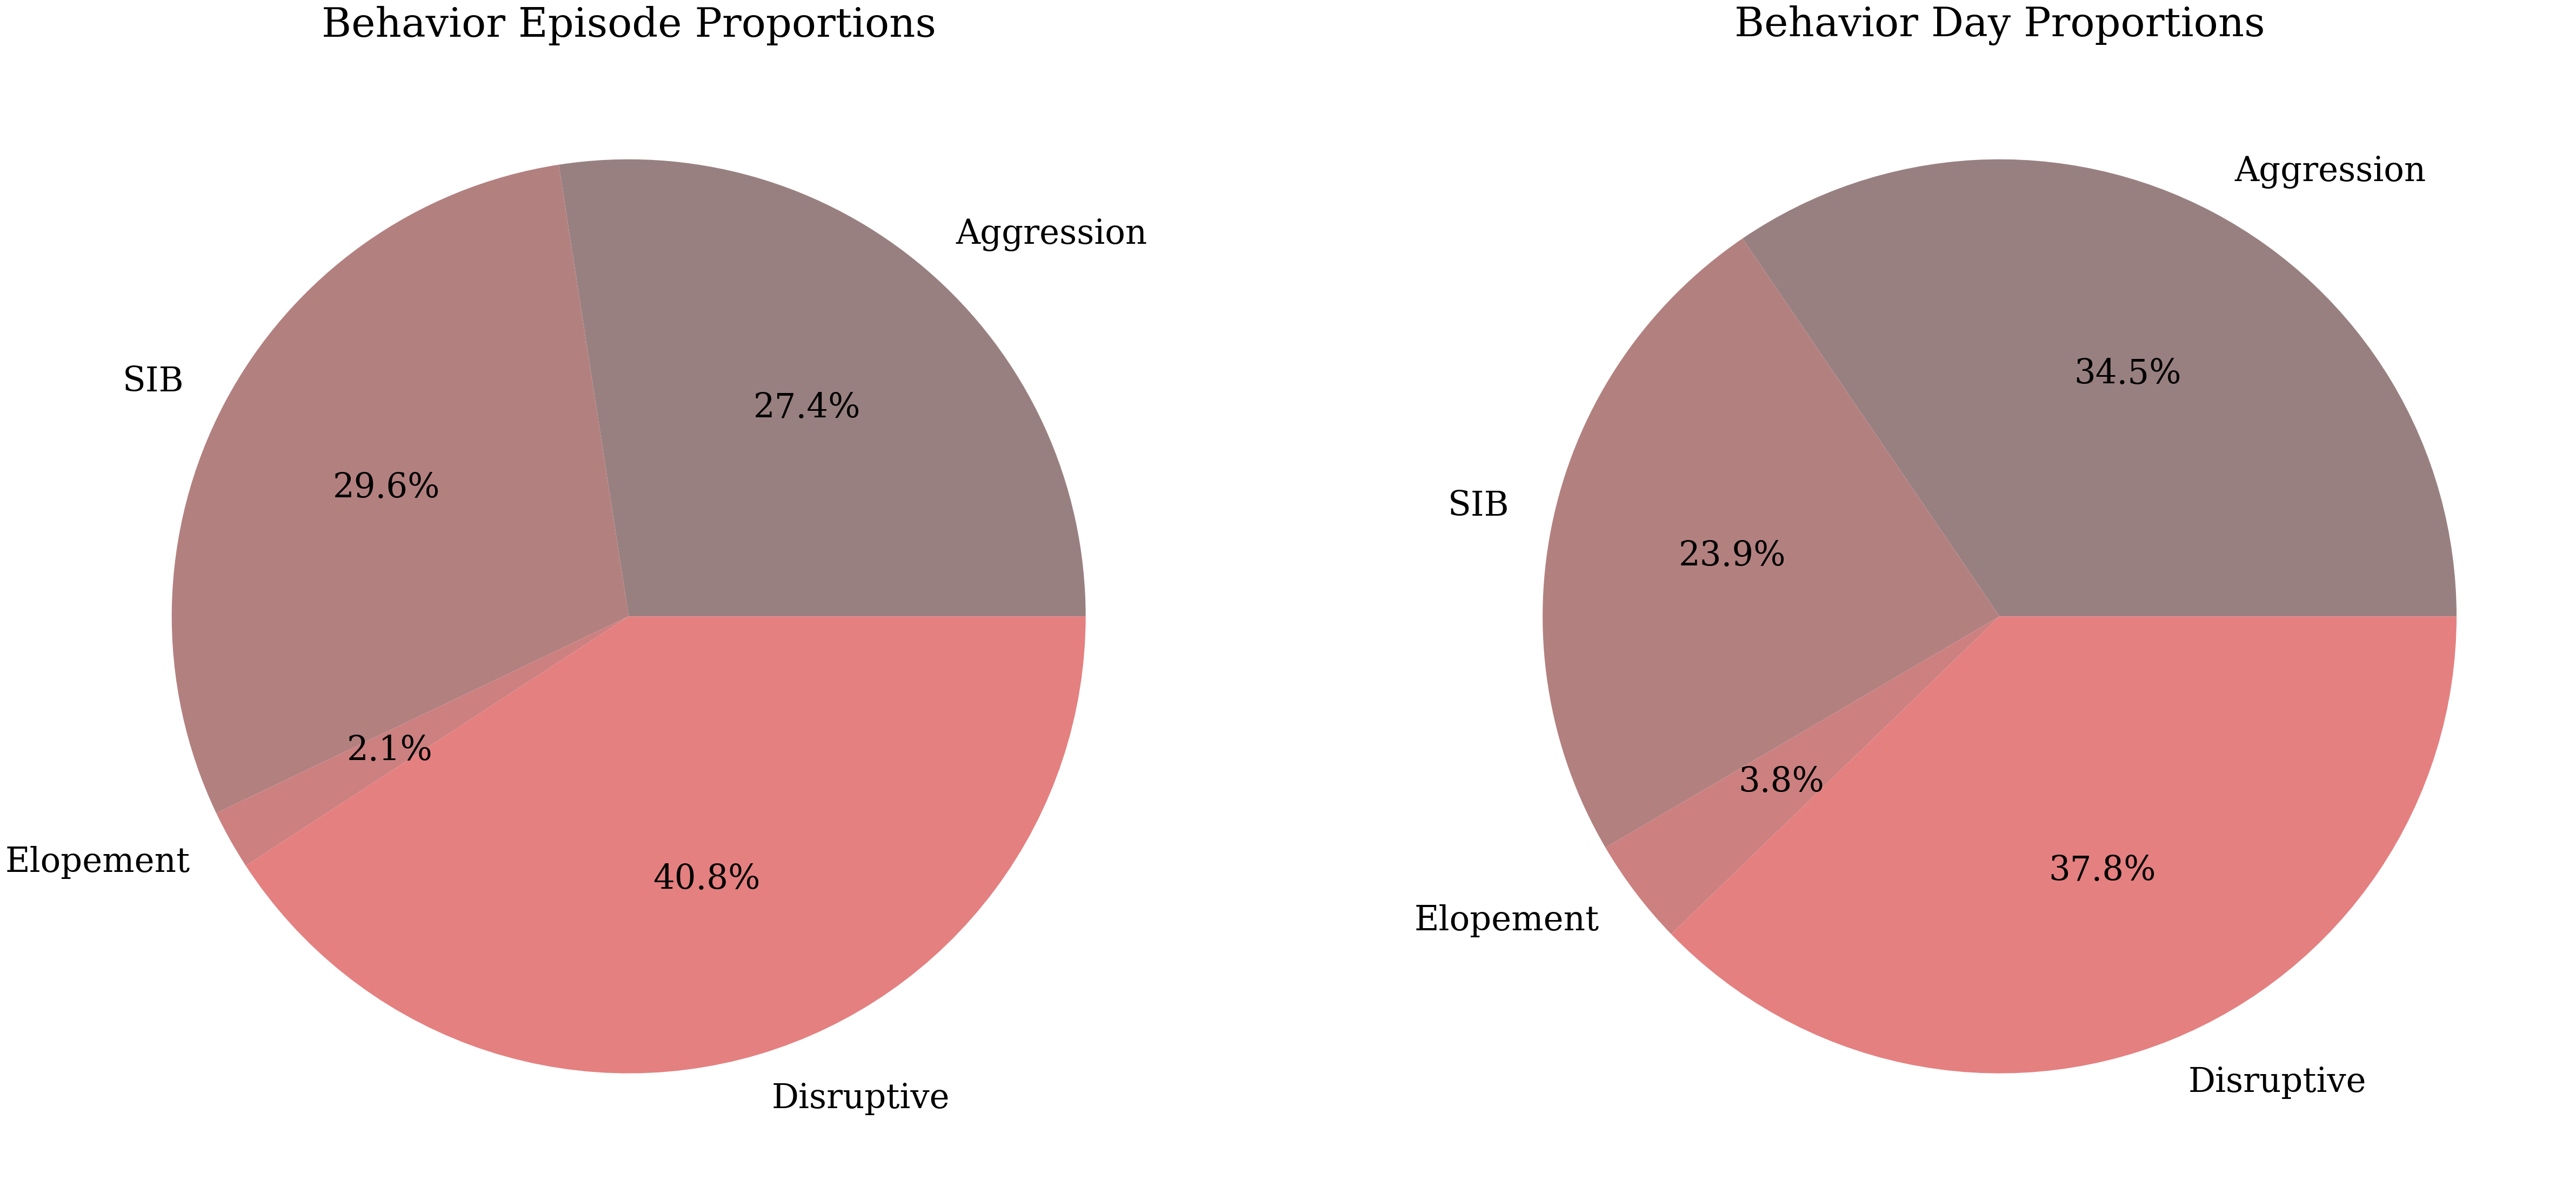

In [64]:
plt.rcParams.update({'font.size': 45})
final_targets = targets.copy()

final_targets = [t.title() for t in final_targets]
final_targets[1] = 'SIB'
fig, ax = plt.subplots(1,2, figsize=(60,30))
color = 0.6
colors =[]
for target in final_targets:
    colors.append((color,0.5,0.5))
    color += 0.1

episode = True
ax[0].pie(get_behavior_totals(targets, targets_episodes, episode), labels=final_targets,autopct='%1.1f%%',colors=colors)
ax[0].set_title('Behavior Episode Proportions')
episode = False
ax[1].pie(get_behavior_totals(targets, targets_days, episode), labels=final_targets,autopct='%1.1f%%',colors=colors)
ax[1].set_title('Behavior Day Proportions')

plt.savefig('outputs/proportions.png')

plt.show()
plt.close()

In [65]:
# demos['Ethnicity'].unique()

In [66]:
# demo_info = demos
# demo_info['Grouped_Ethnicity'] = float("NaN")
# demo_info.loc[demo_info['Ethnicity'].isin(['Caucasian','Albanian','Middle Eastern']), 'Grouped_Ethnicity']  = 'Caucasian'
# demo_info.loc[demo_info['Ethnicity'].isin(['Asian','Indian','Causasian/Asian']), 'Grouped_Ethnicity'] = 'Asian'
# demo_info.loc[demo_info['Ethnicity'].isin(['African Amer.','African-American']), 'Grouped_Ethnicity' ] = 'African Amer.'
# demo_info.loc[demo_info['Ethnicity'].isin(['Hispanic','Hispanic/Middle Eastern','Caucasian/Hispanic','Puerto Rican']), 'Grouped_Ethnicity' ] = 'Hispanic'

In [67]:
# # Get age and sex info for each ID
# import json
# unique_ids = []
# # demo_info = pd.read_csv('demos_covid.csv', index_col=0)
# # # demo_info['Age_At_Start_Date'] = pd.to_datetime(demo_info['Age_At_Start_Date'])
# # # demo_info['Age_At_Start_Date'] = (before_covid - demo_info['Age_At_Start_Date']).dt.days / 365.25
# # demo_info.drop('FirstDate',axis=1,inplace=True)
# # n_precision = 1
# # demo_info['Age_At_Start_Date'] = np.trunc(demo_info['Age_At_Start_Date'] * (10 ** n_precision))/ (10 ** n_precision)
# demo_info = demos

# behavior_demos = {}
# behavior_demos['Behavior Type'] = []
# behavior_demos['Sex'] = []
# behavior_demos['Age mean (sd)'] = []
# behavior_demos['Ethnicity'] = []
# behavior_demos['n'] = []
# for t in range(int(len(targs) / 2)):
#     # print(final_targets[t])
#     ids = behs[t]['Person_ID'].unique().tolist()
#     unique_ids.extend(ids)
#     current_demos = demo_info[demo_info["Person_ID"].isin(ids)].copy()
#     print(current_demos.loc[current_demos['Grouped_Ethnicity'].isna(),'Person_ID'])
#     d = json.loads(current_demos['Sex'].value_counts().to_json())
#     sex_string = "; ".join([k + ": " + str(v) for k, v in d.items()])
#     d = json.loads(round(((current_demos['Grouped_Ethnicity'].value_counts(dropna=False)/len(current_demos))*100),2).to_json())
#     ethnicity_string = "; ".join([k + ": " + str(v) + "\%" for k, v in d.items()])
#     age_string = str(round(current_demos['Age_At_Covid_Date'].mean(),2)) + " (" + str(round(current_demos['Age_At_Covid_Date'].std(ddof=1),2)) + ")"

#     behavior_demos['Behavior Type'].append(targs[t])
#     behavior_demos['Sex'].append(sex_string)
#     behavior_demos['Ethnicity'].append(ethnicity_string)
#     behavior_demos['Age mean (sd)'].append(age_string)
#     behavior_demos['n'].append(str(len(current_demos)))

# l = pd.DataFrame(behavior_demos).to_latex(index=False)
# spl = ''
# spl = l.split('\n')

# spl.insert(0, """\\begin{table}[H] 
#         \caption{Demographics of Cohort\label{tab1}}""")
# spl[1] = spl[1].replace('tabular','tabularx}{\\textwidth')
# spl[-2] = spl[-2].replace('tabular','tabularx')
# spl[1] = spl[1].replace("lllll","CCCCC")
# spl[3] = " & ".join(["\\textbf{" + spl_st.strip() + "}" for spl_st in spl[3].replace("\\\\","").split("&")]) + " \\\\"
# spl.append('\\end{table}')
# l = '\n'.join(spl)
# with open("outputs/demographics.txt", "w") as text_file:
#     text_file.write(l)
   

In [68]:
# pd.DataFrame({'Person_ID':sorted(list(set(unique_ids)))}).to_csv('outputs/unique_ids.csv')

In [69]:
# print(l)


In [70]:
# print(l)
